# Example usage of the Lakeshore Model 372 to control the temperature of the Bluefors fridge

The Lakeshore Temperature Controller Model 372 is used to control the temperature of the Bluefors fridges.

To use it as such outside of the control software provided by Bluefors, one has to establish an addtional connection. Within the Bluefors system, the Lakeshore is connected via its usb port (through a USB hub along with the other devices) to the control Laptop (as part of the Bluefors setup). To control the temperature of the fridge via QCoDeS, it is the most convenient to connect the Lakeshore via its LAN port to the control computer (the one with QCoDeS, not the one from Bluefors). In order to reach the LAN port of the Lakeshore, the Bluefors rack has to be opened, and the PCB board that is fixed to the metal board has to be opened as well (it's a door as well with magnetic clips on one side). Do NOT disconnect the USB! Then switch the operation mode (usually there is an Interface button on the instrument) from USB to LAN. When using a router, remember to set the IP address setting to DHCP. Finally, use the following address format for VISA address: `"TCPIP::<ip address>::<port>::SOCKET"`, where "port" is a known value from the manual (most probably, "7777").

As mentioned above, for using the Lakeshore with QCoDeS, the operation mode has to be switched from USB to LAN. When done with the measurements, please, switch back to USB, so that the logging of the Temperature provided by the Bluefors software continues. It is planned to implement a server that takes care of the logging, so that the switching to USB will no longer be necessary. For the time being, please, always remember to switch back!

## Driver Setup

This notebook is using a simulated version of the driver, so that it can be run and played with, without an actual instrument. When trying it out with a real Lakeshore, please set `simulation = False`.

In [2]:
simulation = False

In [3]:
if simulation:
    from qcodes.tests.drivers.test_lakeshore import Model_372_Mock as Model_372
    import qcodes.instrument.sims as sims
    visalib = sims.__file__.replace('__init__.py',
                                    'lakeshore_model372.yaml@sim')
    ls = Model_372('lakeshore_372', 'GPIB::3::65535::INSTR',
                    visalib=visalib, device_clear=False)
else:
    from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
    #                               put visa address here, see e.g. NI Max
    #                               or look up the IP address on 
    #                               the instrument itself
    ls = Model_372('lakeshore_372', 'TCPIP::192.168.0.160::7777::SOCKET')

Connected to: LSCI 372 (serial:LSA21E7, firmware:1.3) in 0.20s


## Readout Sensor Channels

The lakeshore has two types of *channels*: *Readout channels* and *heaters*. For reading the temperature we use the readout channels. There are sixteen channels, each of which has the following parameters:

In [4]:
ls.ch01.parameters

{'auto_range': <qcodes.instrument.group_parameter.GroupParameter: auto_range at 2243972997808>,
 'current_source_shunted': <qcodes.instrument.group_parameter.GroupParameter: current_source_shunted at 2243972998368>,
 'curve_number': <qcodes.instrument.group_parameter.GroupParameter: curve_number at 2243972850856>,
 'dwell': <qcodes.instrument.group_parameter.GroupParameter: dwell at 2243972852928>,
 'enabled': <qcodes.instrument.group_parameter.GroupParameter: enabled at 2243972852760>,
 'excitation_mode': <qcodes.instrument.group_parameter.GroupParameter: excitation_mode at 2243972997360>,
 'excitation_range_number': <qcodes.instrument.group_parameter.GroupParameter: excitation_range_number at 2243972997696>,
 'pause': <qcodes.instrument.group_parameter.GroupParameter: pause at 2243972853208>,
 'range': <qcodes.instrument.group_parameter.GroupParameter: range at 2243972998088>,
 'sensor_name': <qcodes.instrument.parameter.Parameter: sensor_name at 2243972852312>,
 'sensor_raw': <qcode

All the parameters have docstrings, labels, and units, when applicable.

Some of these parameters have been added just because other interesting parameters can only be set together with these (Lakeshore uses VISA commands with multiple inputs/outputs).

Some parameters like `curve_number` should not be changed, unless the user knows what he's doing.

In order to read temperature values from all the sensors, we can do the following:

In [22]:
for ch in ls.channels:
    print(f'Temperature of {ch.short_name} ({"on" if ch.enabled() else "off"}): {ch.temperature()} {ch.units()}')

Temperature of ch01 (off): 38.1549 kelvin
Temperature of ch02 (off): 2.72274 kelvin
Temperature of ch03 (off): 3.67145 kelvin
Temperature of ch04 (off): 0.0 kelvin
Temperature of ch05 (off): 0.816971 kelvin
Temperature of ch06 (off): 0.0 kelvin
Temperature of ch07 (off): 0.0 kelvin
Temperature of ch08 (off): 0.0 kelvin
Temperature of ch09 (on): 0.0137187 kelvin
Temperature of ch10 (off): 0.0 kelvin
Temperature of ch11 (off): 0.0 kelvin
Temperature of ch12 (off): 0.0 kelvin
Temperature of ch13 (off): 0.0 kelvin
Temperature of ch14 (off): 0.0 kelvin
Temperature of ch15 (off): 0.0 kelvin
Temperature of ch16 (off): 0.0 kelvin


The `enabled` parameter of the sensor channel is very important because Lakeshore gets readings from the enabled channels in sequence. This means that if you have 3 channels enabled, while you are contantly requesting the temperature reading from only the first one, the array of readings will have parts when the value is constant. This is because within those parts Lakeshore was busy with reading temperature from the other two channels.

The `units` parameter is also of big importance. As it will be explained below, it defines the units from the `setpoint` value of the heater that is used in a `closed_loop` mode.

## Heating and feedback loop

To set a certain temperature one needs to start a feedback loop that reads the temperature from a sensor channel, and feeds it back to the sample through a heater. The Lakeshore 372 has three heaters: `sample_heater`, `warmup_heater`, and `analog_heater`.

Here the `sample_heater` will be used. It has the following parameters:

In [6]:
h = ls.sample_heater
h.parameters

{'D': <qcodes.instrument.group_parameter.GroupParameter: D at 2243981545656>,
 'I': <qcodes.instrument.group_parameter.GroupParameter: I at 2243981475680>,
 'P': <qcodes.instrument.group_parameter.GroupParameter: P at 2243981475400>,
 'blocking_t': <qcodes.instrument.parameter.Parameter: blocking_t at 2243981547672>,
 'delay': <qcodes.instrument.group_parameter.GroupParameter: delay at 2243981548400>,
 'input_channel': <qcodes.instrument.group_parameter.GroupParameter: input_channel at 2243981474672>,
 'mode': <qcodes.instrument.group_parameter.GroupParameter: mode at 2243981474504>,
 'output_range': <qcodes.instrument.parameter.Parameter: output_range at 2243981545992>,
 'polarity': <qcodes.instrument.group_parameter.GroupParameter: polarity at 2243981547784>,
 'powerup_enable': <qcodes.instrument.group_parameter.GroupParameter: powerup_enable at 2243981474896>,
 'range_limits': <qcodes.instrument.parameter.Parameter: range_limits at 2243981546776>,
 'setpoint': <qcodes.instrument.par

The allowed modes, polarities, and ranges are defined in:

In [7]:
h.MODES

{'closed_loop': 5,
 'monitor_out': 1,
 'off': 0,
 'open_loop': 2,
 'still': 4,
 'warm_up': 6,
 'zone': 3}

In [8]:
h.RANGES

{'100mA': 8,
 '100μA': 2,
 '10mA': 6,
 '1mA': 4,
 '3.16mA': 5,
 '31.6mA': 7,
 '31.6μA': 1,
 '316μA': 3,
 'off': 0}

In [9]:
h.POLARITIES

{'bipolar': 1, 'unipolar': 0}

### Working with closed loop control

To use a closed loop control, we need to set the `P`, `I`, `D` values, choose an `input_channel` that will be read within the closed loop, set the range of the heater (`output_range`), set the `setpoint` value (e.g. the target temperature), and start the operation by setting `mode` to `closed_loop`.

In [28]:
h.P(1)
h.I(2)
h.D(2)
h.output_range('1mA')
h.input_channel(9)

In [29]:
h.setpoint(0.025)
h.mode('closed_loop')

#### Units of the setpoint

Be careful when setting the value of the `setpoint` - Lakeshore uses "preferred units" for it which are determined by the `units` parameter of the chosen `input_channel`. Thanks to that, Lakeshore 372 supports setting `setpoint` in `ohms` and `kelvins`.

In [30]:
ls.ch09.units()

'kelvin'

In [31]:
print(h.setpoint.__doc__)  # when working in Jupyter, just use `h.setpoint?` syntax

The value of the setpoint in the preferred units of the control loop sensor (which is set via `input_channel` parameter)

Parameter class:

* `name` setpoint
* `label` Setpoint value (in sensor units)
* `unit` 
* `vals` <Numbers 0<=v<=400>


#### Disable unrelated channels for continuos readings

Note that in order to have Lakeshore constantly reading from the `input_channel`, you need to disable other channels. Otherwise, Lakeshore will be reading all the enabled channels one by one, which will slow down the convergence of the control loop.

In [16]:
ls.ch03.enabled(False)

#### Observe control loop working

Now we can observe how the temperature gets steered towards the setpoint (This is not implemented in the simulated instrument)

In [42]:
import time
for i in range(20):
    time.sleep(1)
    print(f'T = {ls.ch09.temperature()}')

T = 0.0262632
T = 0.0261551
T = 0.0260708
T = 0.0260076
T = 0.0259394
T = 0.0258739
T = 0.0257804
T = 0.0256941
T = 0.025619
T = 0.0255518
T = 0.0254828
T = 0.0254278
T = 0.0253904
T = 0.0253381
T = 0.0252681
T = 0.0252402
T = 0.0252381
T = 0.025216
T = 0.0251675
T = 0.0250843


Textual representation is not very convenient, hence let's do the same but now with plotting (This is not implemented in the simulated instrument):

In [43]:
%matplotlib notebook

import time
import numpy
from IPython.display import display
from ipywidgets import interact, widgets
from matplotlib import pyplot as plt

def live_plot_temperature_reading(channel_to_read, read_period=0.2, n_reads=1000):
    """
    Live plot the temperature reading from a Lakeshore sensor channel
    
    Args:
        channel_to_read
            Lakeshore channel object to read the temperature from
        read_period
            time in seconds between two reads of the temperature
        n_reads
            total number of reads to perform
    """

    # Make a widget for a text display that is contantly being updated
    text = widgets.Text()
    display(text)

    fig, ax = plt.subplots(1)
    line, = ax.plot([], [], '*-')
    ax.set_xlabel('Time, s')
    ax.set_ylabel(f'Temperature, {channel_to_read.units()}')
    fig.show()
    plt.ion()

    for i in range(n_reads):
        time.sleep(read_period)

        # Update the text field
        text.value = f'T = {channel_to_read.temperature()}'

        # Add new point to the data that is being plotted
        line.set_ydata(numpy.append(line.get_ydata(), channel_to_read.temperature()))
        line.set_xdata(numpy.arange(0, len(line.get_ydata()), 1)*read_period)

        ax.relim()  # Recalculate limits
        ax.autoscale_view(True, True, True)  # Autoscale
        fig.canvas.draw()  # Redraw

Text(value='')

<IPython.core.display.Javascript object>


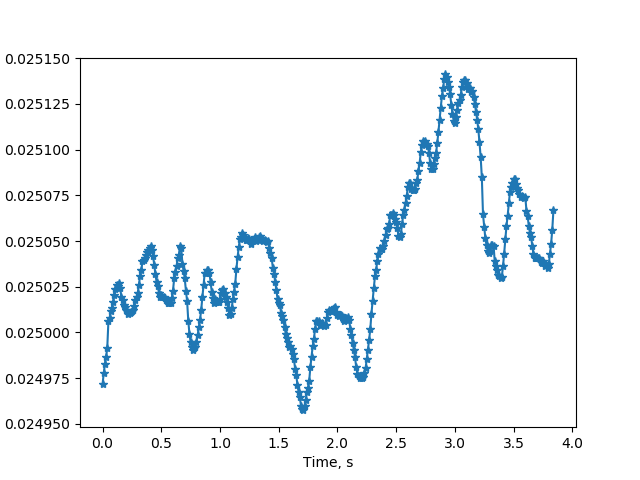

KeyboardInterrupt: 

In [47]:
live_plot_temperature_reading(channel_to_read=ls.ch09, read_period=0.01, n_reads=999)

## Waiting to reach setpoint
As we have seen, the call of the parameter `setpoint` is non-blocking. That means the function returns imediately without waiting for the setpoint to be reached. In many use-cases it is desirable to wait until a certain temperature regime has been reached. This can be achieved with `wait_until_set_point_reached` method. There are also three parameters which allow to tune the behavior of this method.

See below:

In [17]:
# time before reading the next temperature value
# in other words, wait half a second, then read the temperature and compare to setpoint
h.wait_cycle_time(0.5)

# wait until temperature within 5% of the setpoint
# the tolerance is defined as: |t_reading-t_setpoint|/t_reading
h.wait_tolerance(0.05)

# wait until temperature has been within the tolerance zone
# for `wait_equilibration_time` seconds
h.wait_equilibration_time(1.5)

In [18]:
# do the waiting:
if not simulation:  # does not work with simulated instrument!
    h.wait_until_set_point_reached()

For the simulation purposes, we can fake the heating of the sample by calling the `start_heating` method which only exists for the simulated instrument.

In [19]:
if simulation:
    ls.sample_heater.setpoint(4)
    ls.start_heating()  # starts from 7K and goes down to the setpoint of 4K
    ls.sample_heater.wait_until_set_point_reached()

## Automatically selecting a heater range (based on temperature)
To automatically select a heater range, one can define temperature limits for the individual heater ranges:

In [20]:
# all limits in K, 8 limits starting with limit for 31.6μA range
h.range_limits([0.021, 0.1, 0.2, 1.1, 2, 4, 8, 16])

In [21]:
list(h.RANGES.keys())

['off', '31.6μA', '100μA', '316μA', '1mA', '3.16mA', '10mA', '31.6mA', '100mA']

This means: from `0 K` to `0.021 K` use `31.6μA`, from `0.021 K` to `0.1 K` use `100μA`, and so on.

We can now set the range by giving a temperature using the `set_range_from_temperature` method:

In [22]:
h.set_range_from_temperature(0.15)
h.output_range()

'316μA'

## Sweeping/blocking paramameter
For compatibility with the legacy Loop construct, the Lakeshore driver exposes a blocking temperature parameter: `blocking_t`.
The setter for this parameter simply does:

```python
def _set_blocking_t(self, t):
     self.set_range_from_temperature(t)
     self.setpoint(t)
     self.wait_until_set_point_reached()
```

This parameter can be used in a `doNd`-like loop.

Note that the range only gets set at the beginning of the sweep, i.e. according to the setpoint not according to the temperature reading.